# 📉 Bitcoin Price Forecasting using ARIMA

This notebook demonstrates classical time series forecasting of the BTC/USD exchange rate using the ARIMA model.

We follow these main steps:

- Load and prepare the dataset
- Explore and visualize the data
- Check and enforce stationarity
- Identify the ARIMA model order
- Fit and evaluate the model
- Forecast and visualize predictions

The dataset spans from February 2012 to October 2024, sourced from Investing.com.

## 📥 Step 1: Load and Prepare the Dataset

We load the BTC/USD historical data, clean and format it, and set the `Date` column as the index for time series analysis.


In [22]:
# 📚 Libraries Import

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# Time series and statistical modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Auto ARIMA for order selection
from pmdarima import auto_arima

# Metrics for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [23]:
data_btc_usd = pd.read_csv('../data/BTC_USD.csv')
data_btc_usd.rename(columns={"Price": "BTC-USD"}, inplace=True)
data_btc_usd["Date"] = pd.to_datetime(data_btc_usd["Date"], errors="coerce")
data_btc_usd["BTC-USD"] = data_btc_usd["BTC-USD"].replace({r'\,': ''}, regex=True).astype(float)
data_btc_usd.set_index('Date', inplace=True)
data_btc_usd.info()
data_btc_usd

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4713 entries, 2024-12-31 to 2012-02-02
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BTC-USD  4713 non-null   float64
dtypes: float64(1)
memory usage: 73.6 KB


,BTC-USD
Date,
2024-12-31,93780.0
2024-12-30,92982.0
2024-12-29,93944.0
2024-12-28,95533.0
2024-12-27,94419.0
...,...
2012-02-06,5.4
2012-02-05,5.7
2012-02-04,5.9


## 📊 Step 2: Visualize the Raw BTC/USD Exchange Rate

We plot the raw exchange rate to observe overall trends and patterns over time.

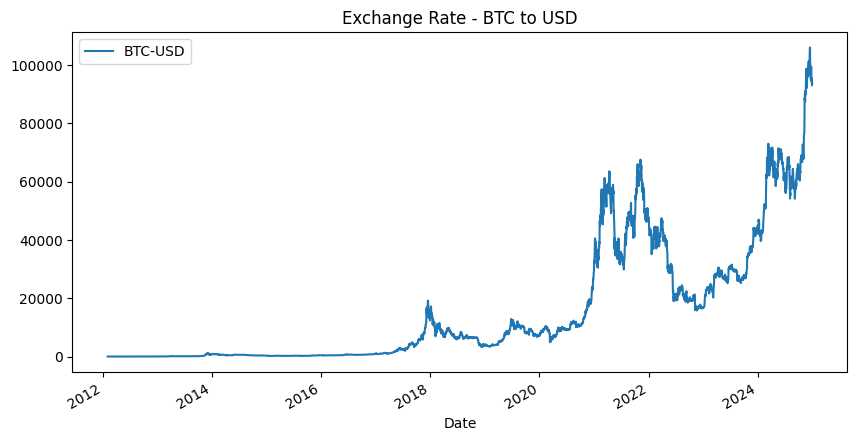

In [24]:
data_btc_usd.plot(figsize=(10,5))
plt.title('Exchange Rate - BTC to USD')
plt.show()

## 🔄 Step 3: Resample Data to Daily Frequency

Resample the dataset to daily frequency using mean aggregation to handle any missing days and smooth the series.

In [25]:
df_day = data_btc_usd.resample('D').mean()
print('Count of The daily Data Frame : ', df_day.shape[0])
df_day.info()
df_day = df_day.dropna()

Count of The daily Data Frame :  4717
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4717 entries, 2012-02-02 to 2024-12-31
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BTC-USD  4713 non-null   float64
dtypes: float64(1)
memory usage: 73.7 KB


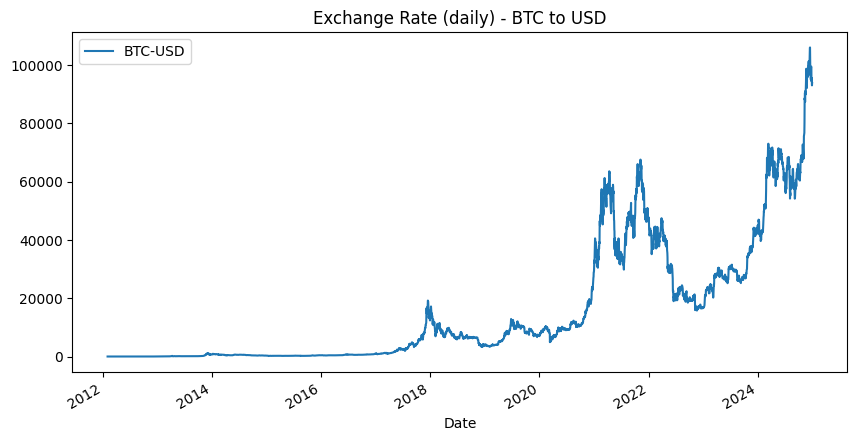

In [26]:
df_day.plot(figsize=(10,5))
plt.title('Exchange Rate (daily) - BTC to USD')
plt.show()

## 📈 Step 4: Distribution Analysis of Daily Exchange Rate

Examine the data distribution using histogram and kernel density estimation to understand variability.

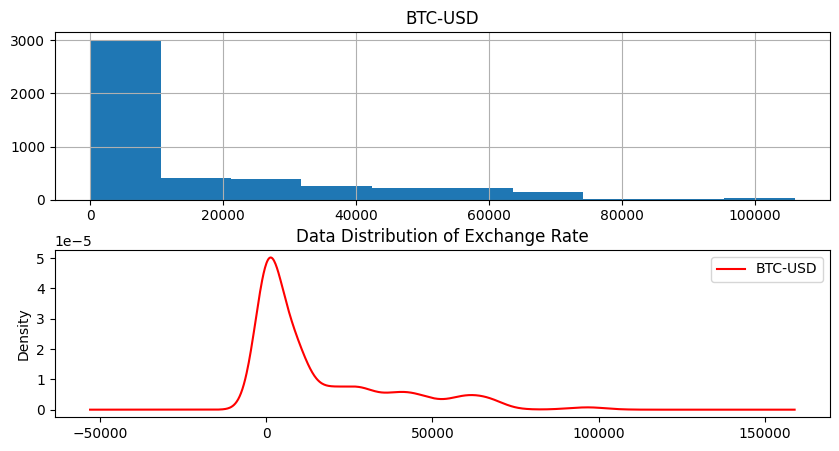

In [27]:
fig , (ax1,ax2) = plt.subplots(nrows = 2 ,ncols = 1,sharex = False , sharey = False , figsize = (10,5))
df_day.hist(ax = ax1)
df_day.plot(kind = 'kde' , ax = ax2,c = 'r')
plt.title('Data Distribution of Exchange Rate')
plt.show()

## 🔍 Step 5: Time Series Decomposition

Decompose the daily exchange rate into trend, seasonal, and residual components to explore underlying patterns.

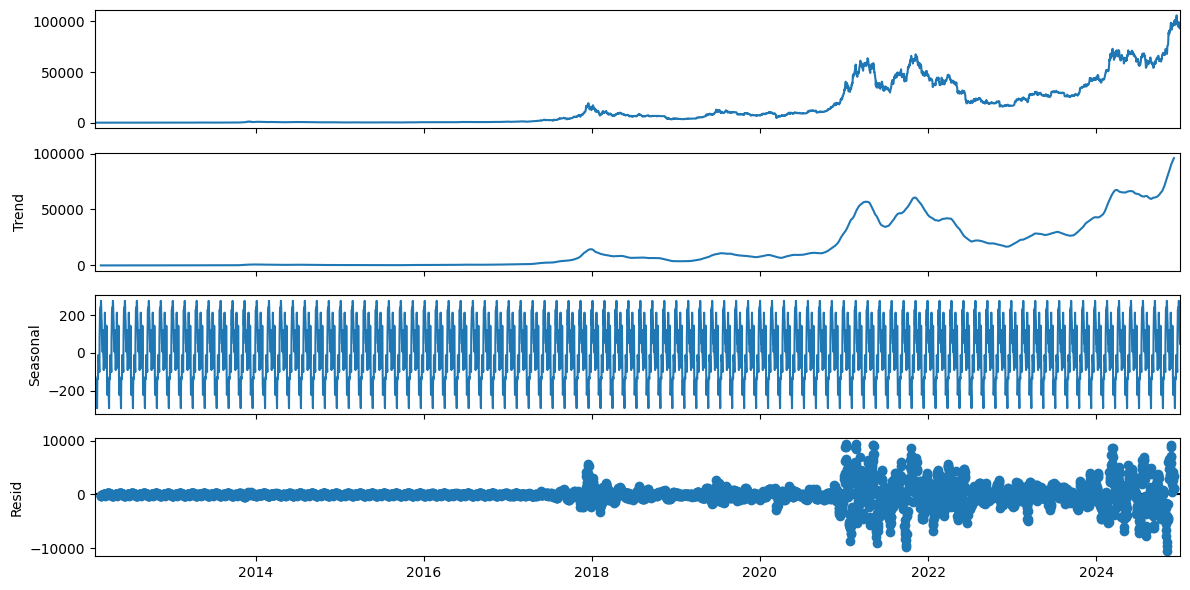

In [28]:
plt.rcParams['figure.figsize'] = (12,6)
decomposition = seasonal_decompose(df_day, period=52, model='additive')
decomposition.plot()
plt.show()

## 📉 Step 6: Autocorrelation and Partial Autocorrelation Plots

Plot ACF and PACF to help identify the AR and MA terms for the ARIMA model.

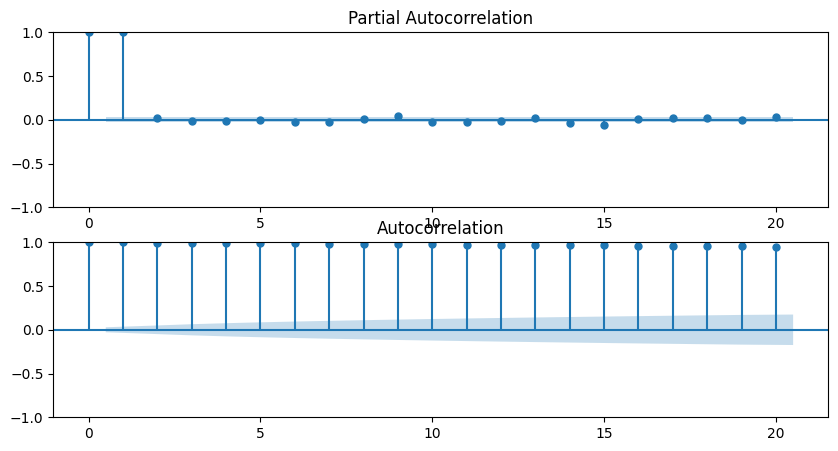

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
plot_pacf(df_day, lags=20, ax=ax1)
plot_acf(df_day, lags=20, ax=ax2)
plt.show()

## 🧪 Step 7: Stationarity Test Using Augmented Dickey-Fuller (ADF) Test

Check if the series is stationary. If not, differencing will be applied.

In [30]:
def adf_check(time_series):
    result = adfuller(time_series , autolag = 'AIC')
    label = pd.Series(result[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        label['Critical Value (%s)'%key] = value
    print(label)
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary')
    else:
        print ('Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary')

In [31]:
adf_check(df_day['BTC-USD'])

Test Statistic                    0.078410
p-value                           0.964556
Number of Lags Used              31.000000
Number of Observations Used    4681.000000
Critical Value (1%)              -3.431748
Critical Value (5%)              -2.862158
Critical Value (10%)             -2.567099
dtype: float64
Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary


## 🔄 Step 8: Differencing to Achieve Stationarity

Apply first-order differencing to remove trends and re-test stationarity.

In [32]:
df1_day = df_day.diff().dropna()

print('First 5 rows of differenced series:')
print(df1_day.head())

First 5 rows of differenced series:
            BTC-USD
Date               
2012-02-03     -0.1
2012-02-04     -0.1
2012-02-05     -0.2
2012-02-06     -0.3
2012-02-07      0.3


In [33]:
adf_check(df1_day['BTC-USD'])

Test Statistic                -9.535745e+00
p-value                        2.811960e-16
Number of Lags Used            3.200000e+01
Number of Observations Used    4.679000e+03
Critical Value (1%)           -3.431748e+00
Critical Value (5%)           -2.862158e+00
Critical Value (10%)          -2.567099e+00
dtype: float64
Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary


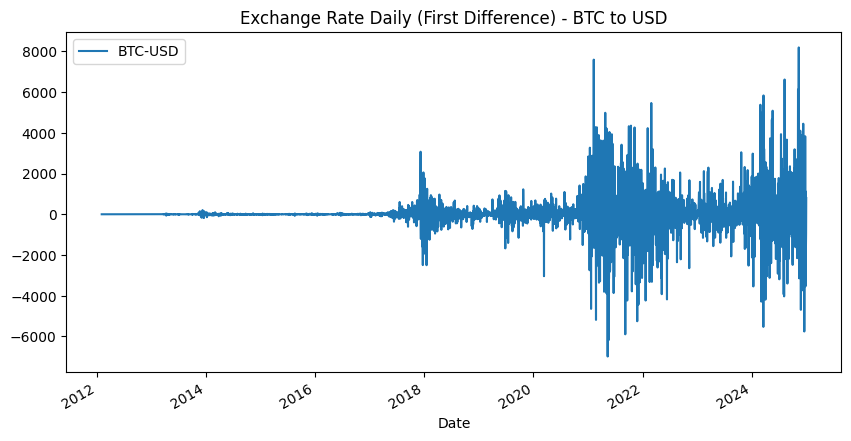

In [34]:
df1_day.plot(figsize=(10,5))
plt.title('Exchange Rate Daily (First Difference) - BTC to USD')
plt.show()

## 📉 Step 9: Visualize Autocorrelation Before and After Differencing

Compare autocorrelation plots of original and differenced series to confirm stationarity.

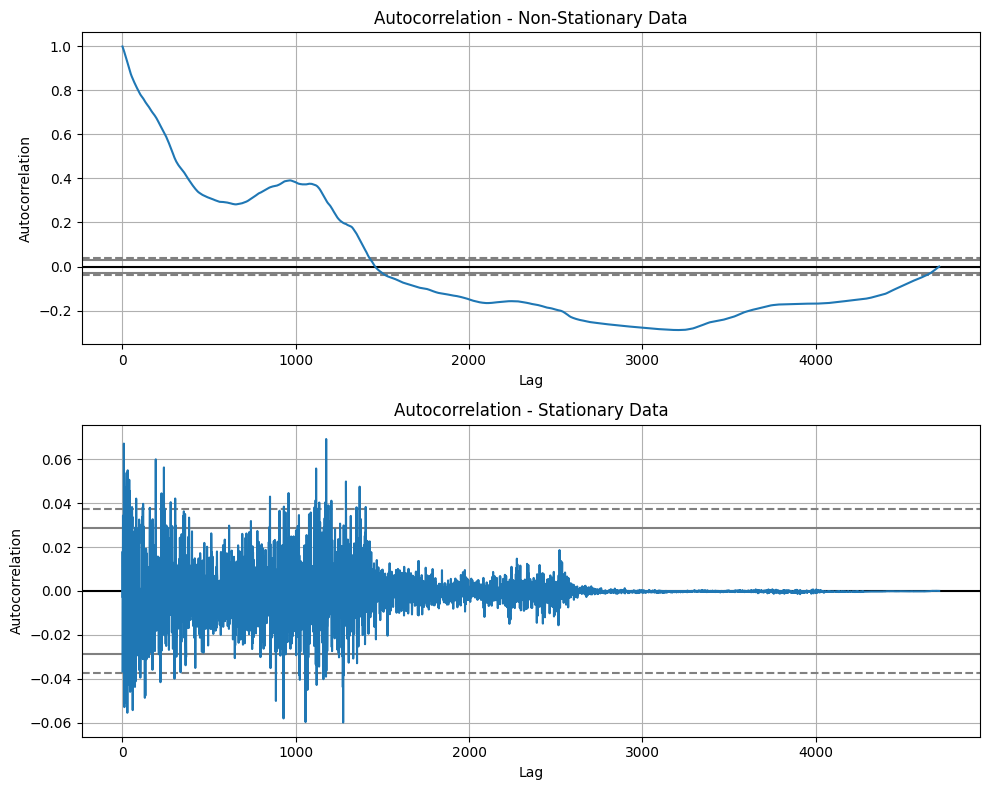

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
autocorrelation_plot(df_day['BTC-USD'], ax=ax1)
ax1.set_title('Autocorrelation - Non-Stationary Data')
autocorrelation_plot(df1_day['BTC-USD'], ax=ax2)
ax2.set_title('Autocorrelation - Stationary Data')
plt.tight_layout()
plt.show()

## 🔍 Step 10: Identify ARIMA Model Order using auto_arima

Use `auto_arima` to select the best model order based on AIC.

In [36]:
model = auto_arima(df_day['BTC-USD'], seasonal=False, m=52, d=1, max_order=8, test='adf', trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=76802.405, Time=4.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76816.019, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76811.672, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76811.890, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76816.672, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=76814.475, Time=1.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=76814.324, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=76807.251, Time=3.96 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=76817.410, Time=3.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=76812.280, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=76816.503, Time=0.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=76816.362, Time=0.47 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=76806.371, Time=2.17 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=76810.939, Time=1.63 sec

Best model:  ARIMA

In [37]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4713
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -38395.202
Date:                Thu, 29 May 2025   AIC                          76802.405
Time:                        00:41:53   BIC                          76841.152
Sample:                             0   HQIC                         76816.026
                               - 4713                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.3761     12.730      1.522      0.128      -5.573      44.326
ar.L1          0.8287      0.027     30.933      0.000       0.776       0.881
ar.L2         -0.8750      0.023    -37.575      0.0

## 🔨 Step 11: Fit ARIMA Model

Fit the selected ARIMA model (2,1,2) and visualize diagnostic plots.

In [38]:
model = ARIMA(df_day['BTC-USD'], order=(2,1,2))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                BTC-USD   No. Observations:                 4713
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -38400.470
Date:                Thu, 29 May 2025   AIC                          76810.939
Time:                        00:41:54   BIC                          76843.229
Sample:                             0   HQIC                         76822.290
                               - 4713                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6038      0.135      4.473      0.000       0.339       0.868
ar.L2          0.3521      0.135      2.605      0.009       0.087       0.617
ma.L1         -0.6390      0.137     -4.653      0.000      -0.908      -0.370
ma.L2         -0.3061      0.137     -2.232      0.026      -0.575      -0.037
sigma2      7.034e+05   4759.582    147.780      0.000    6.94e+05    7.13e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             55030.28
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):            5235.23   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

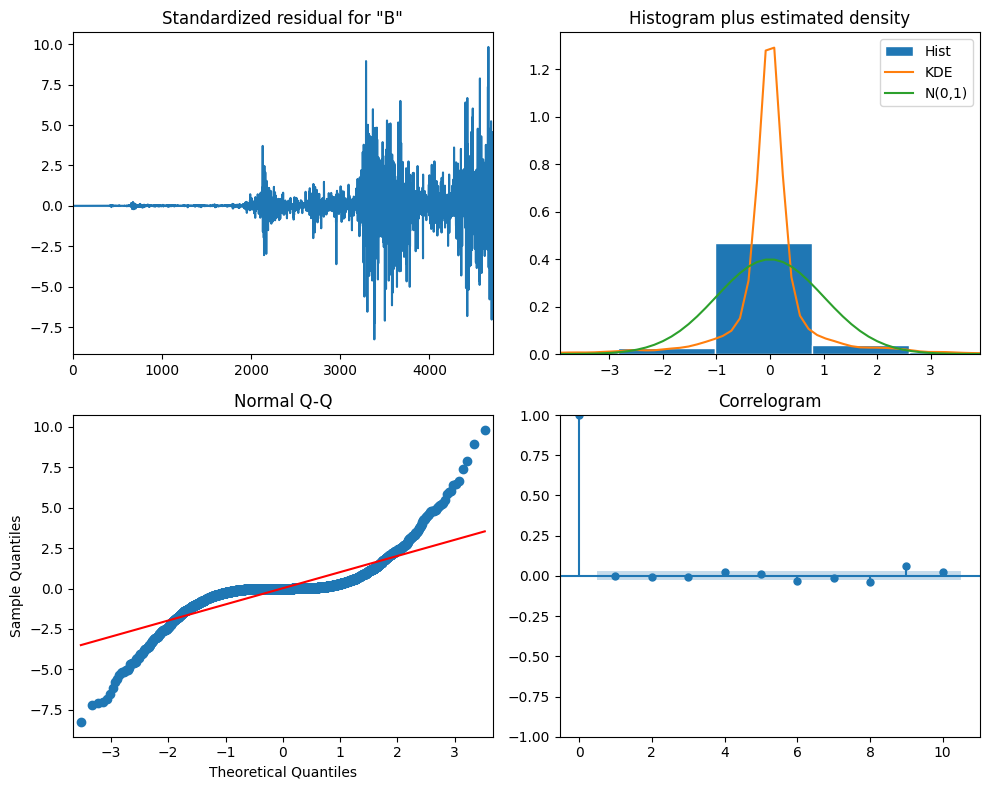

In [39]:
result.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

## 🚦 Step 12: Train-Test Split

Split data into training (80%) and testing (20%) sets for model evaluation.


In [40]:
size = int(len(df_day)*0.8)
train = df_day['BTC-USD'][:size]
test = df_day['BTC-USD'][size:]

print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Train size: 3770
Test size: 943


## 📊 Step 13: Train ARIMA Model on Training Data and Forecast

Fit ARIMA on training data and forecast the entire test set at once.

In [41]:
train_values = train.tolist()
model = ARIMA(train_values, order=(3,1,2), enforce_stationarity=False)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))
print(forecast)

[30530.62703266 30511.3251335  30484.20176022 30467.47935031
 30461.98264046 30462.73080103 30465.17688698 30467.03824893
 30467.83948665 30467.91939696 30467.72558389 30467.53247668
 30467.42969947 30467.40448403 30467.41645692 30467.43503332
 30467.44710699 30467.45141593 30467.45116927 30467.44954445
 30467.44822599 30467.44762311 30467.44753607 30467.44765872
 30467.44779288 30467.44786822 30467.44788913 30467.44788244
 30467.44786982 30467.44786115 30467.44785782 30467.44785779
 30467.44785886 30467.44785979 30467.44786024 30467.44786032
 30467.44786025 30467.44786015 30467.4478601  30467.44786008
 30467.44786009 30467.44786009 30467.4478601  30467.4478601
 30467.4478601  30467.4478601  30467.4478601  30467.4478601
 30467.4478601  30467.4478601  30467.4478601  30467.4478601
 30467.4478601  30467.4478601  30467.4478601  30467.4478601
 30467.4478601  30467.4478601  30467.4478601  30467.4478601
 30467.4478601  30467.4478601  30467.4478601  30467.4478601
 30467.4478601  30467.4478601 

## 🔄 Step 14: Step-wise Forecasting with Model Updating

Forecast one-step ahead, updating the training set with actual test values after each prediction.

In [42]:
prediction = []
history = train_values.copy()

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2), enforce_stationarity=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(float(yhat))
    history.append(test.iloc[t])
    print(f'Predicted = {yhat:.4f}, Actual = {test.iloc[t]:.4f}')

Predicted = 30621.0914, Actual = 29730.0000
Predicted = 29693.6277, Actual = 29877.0000
Predicted = 29701.2735, Actual = 29923.4000
Predicted = 29811.9088, Actual = 31371.0000
Predicted = 31379.6702, Actual = 31149.0000
Predicted = 31294.2427, Actual = 30230.0000
Predicted = 30387.1107, Actual = 30112.2000
Predicted = 30098.3268, Actual = 29103.0000
Predicted = 28993.4136, Actual = 28425.0000
Predicted = 28347.9231, Actual = 26670.0000
Predicted = 26786.9275, Actual = 22487.0000
Predicted = 22770.6136, Actual = 22172.0000
Predicted = 22286.5004, Actual = 22594.0000
Predicted = 22408.8963, Actual = 20394.0000
Predicted = 20211.6013, Actual = 20411.0000
Predicted = 20426.3930, Actual = 18978.0000
Predicted = 19196.3327, Actual = 20556.0000
Predicted = 20672.9566, Actual = 20554.1000
Predicted = 20441.8966, Actual = 20692.9000
Predicted = 20491.8017, Actual = 19943.0000
Predicted = 19895.4564, Actual = 21071.0000
Predicted = 21183.9979, Actual = 21229.0000
Predicted = 21373.2164, Actual =

## 📈 Step 15: Plot Actual vs Predicted Exchange Rates

Visualize how well the model forecasts BTC/USD prices on the test set.


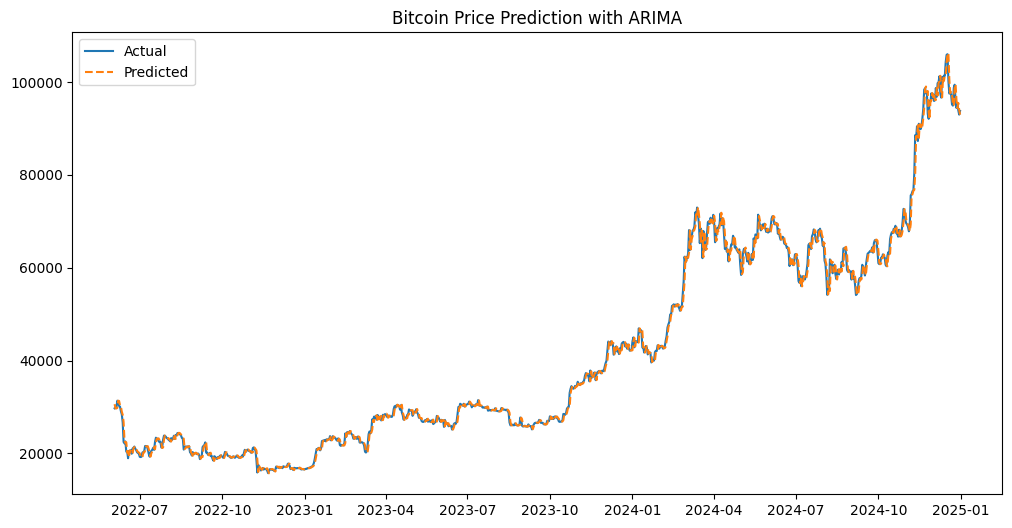

In [43]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, prediction, label='Predicted', linestyle='--')
plt.title('Bitcoin Price Prediction with ARIMA')
plt.legend()
plt.show()

## 🧮 Step 16: Evaluate Forecast Performance

Calculate and display key error metrics: MAE, MSE, RMSE, MAPE, and accuracy.

In [44]:
mae = mean_absolute_error(test, prediction)
mse = mean_squared_error(test, prediction)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - prediction) / test)) * 100
accuracy = 100 - mape

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')
print(f'Accuracy: {accuracy:.4f}%')

Mean Absolute Error (MAE): 781.6967
Mean Squared Error (MSE): 1592731.4925
Root Mean Squared Error (RMSE): 1262.0347
Mean Absolute Percentage Error (MAPE): 1.8506%
Accuracy: 98.1494%
